In [1]:
# download required libraries
!pip install -U segmentation_models --quiet
!pip install dicom2nifti --quiet
!pip install nilearn --quiet
!rm -rf sample_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 73.1 MB/s eta 0:00:00


In [1]:
# import required libraries
import segmentation_models as sm
# you have to delete the "generic_utils" from the file that makes the segmentatin_models import fail:
# from this:  keras.utils.generic_utils.get_custom_objects().update(custom_objects)
# to this:    keras.utils.get_custom_objects().update(custom_objects)
# then: save the file + restart the runtime
import zipfile
import gdown
import numpy as np
import random
import gc
import csv
import keras
from google.colab import files
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.metrics import MeanIoU, Precision, Recall
from keras.models import load_model

Segmentation Models: using `keras` framework.


In [6]:
model_name = "fpn"
n_classes = 4

In [3]:
# faster download of the ACDC dataset, completely the same as the one available on the official website
file_id = '1qAUJtiPZfT3jm4V4qg-VRVucpZva-Qj_'
gdown.download(f'https://drive.google.com/uc?id={file_id}', '/content/ACDC.zip', quiet=False)
zipfile.ZipFile('/content/ACDC.zip', 'r').extractall('/content')

# only use this if you just want to run the tests, and evaluation, and dont want to train the model
# file_id = '1QwfRAiRYlQr3gIKzMQgcrkyJy-6uXDI6'
# gdown.download(f'https://drive.google.com/uc?id={file_id}', '/content/ACDC.zip', quiet=False)
# zipfile.ZipFile('/content/ACDC.zip', 'r').extractall('/content')

Downloading...
From: https://drive.google.com/uc?id=1qAUJtiPZfT3jm4V4qg-VRVucpZva-Qj_
To: /content/ACDC.zip
100%|██████████| 2.45G/2.45G [00:30<00:00, 79.2MB/s]


In [4]:
%run prep.py

 - - - preprocessing started - - - 
x_train shape:		 (1000, 256, 256, 3)
x_train_aug shape:	 (625, 256, 256, 3)
y_train shape:		 (1000, 256, 256, 1)
y_train_aug shape:	 (625, 256, 256, 1)
x_test shape:		 (500, 256, 256, 3)
x_test_aug shape:	 (250, 256, 256, 3)
y_test shape:		 (500, 256, 256, 1)
y_test_aug shape:	 (250, 256, 256, 1)
 - - - preprocessing finished - - - 


In [5]:
gc.collect()

0

In [2]:
x_train = np.load('x_train.npz')['arr_0']
y_train = np.load('y_train.npz')['arr_0']
x_test = np.load('x_test.npz')['arr_0']
y_test = np.load('y_test.npz')['arr_0']

x_train_aug = np.load('x_train_aug.npz')['arr_0']
y_train_aug = np.load('y_train_aug.npz')['arr_0']
x_test_aug = np.load('x_test_aug.npz')['arr_0']
y_test_aug = np.load('y_test_aug.npz')['arr_0']

x_train = np.clip(np.concatenate((x_train, x_train_aug), axis=0), 0.0, 1.0)
y_train = np.concatenate((y_train, y_train_aug), axis=0)
x_test = np.clip(np.concatenate((x_test, x_test_aug), axis=0), 0.0, 1.0)
y_test = np.concatenate((y_test, y_test_aug), axis=0)

y_train = np.round(3*y_train)
y_test = np.round(3*y_test)

print("x_train: \t", x_train.shape, np.min(x_train), np.max(x_train), "\n", x_train[0][128][120:125])
print("y_train: \t", y_train.shape, np.min(y_train), np.max(y_train), "\n", y_train[0][128][120:125])
print("\tlabels:\t", np.unique(y_train), "\n")
print("x_test: \t", x_test.shape, np.min(x_test), np.max(x_test), "\n", x_test[0][128][120:125])
print("y_test: \t", y_test.shape, np.min(y_test), np.max(y_test), "\n", y_test[0][128][120:125])
print("\tlabels:\t", np.unique(y_test), "\n")


x_train: 	 (1625, 256, 256, 3) 0.0 1.0 
 [[0.43934768 0.43934768 0.43934768]
 [0.46298486 0.46298486 0.46298486]
 [0.46649534 0.46649534 0.46649534]
 [0.44976535 0.44976535 0.44976535]
 [0.48642975 0.48642975 0.48642975]]
y_train: 	 (1625, 256, 256, 1) 0.0 3.0 
 [[3.]
 [3.]
 [3.]
 [3.]
 [3.]]
	labels:	 [0. 1. 2. 3.] 

x_test: 	 (750, 256, 256, 3) 0.0 1.0 
 [[0.6211397  0.6211397  0.6211397 ]
 [0.55925244 0.55925244 0.55925244]
 [0.5973652  0.5973652  0.5973652 ]
 [0.6121324  0.6121324  0.6121324 ]
 [0.63419116 0.63419116 0.63419116]]
y_test: 	 (750, 256, 256, 1) 0.0 3.0 
 [[3.]
 [3.]
 [3.]
 [3.]
 [3.]]
	labels:	 [0. 1. 2. 3.] 



random number generaterd:  338


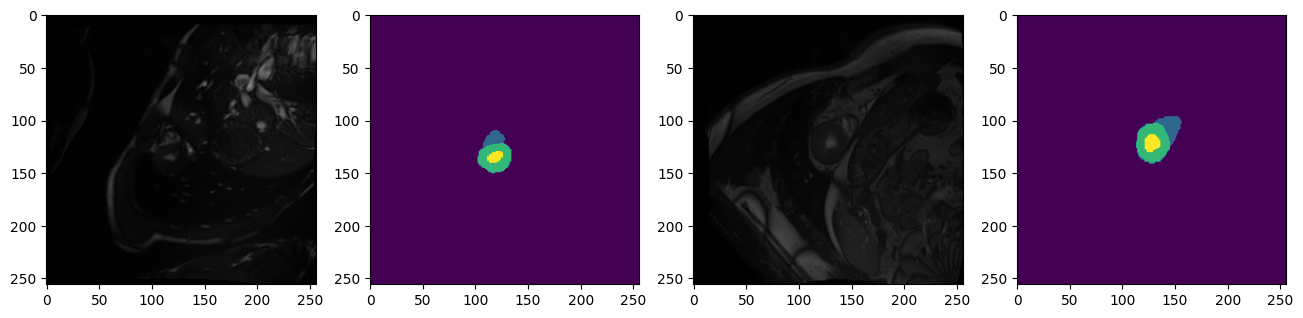

In [ ]:
i = random.randint(0, len(y_test)-1)
print("random number generaterd: ", i)
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(x_train[i])
plt.subplot(142)
plt.imshow(y_train[i])
plt.subplot(143)
plt.imshow(x_test[i])
plt.subplot(144)
plt.imshow(y_test[i])

In [3]:
# build the model, and compile it
BACKBONE = 'resnet34'
BATCH_SIZE = 8
EPOCHS = 20
LR = 0.0001
n_classes = 4
preprocess_input = sm.get_preprocessing(BACKBONE)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.16, random_state=42)

y_train_cat = to_categorical(y_train, num_classes=n_classes).reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
y_val_cat = to_categorical(y_val, num_classes=n_classes).reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))
y_test_cat = to_categorical(y_test, num_classes=n_classes).reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_cat.shape, y_val_cat.shape, y_test_cat.shape)

print("y_train_cat: \t", y_train_cat.shape, np.min(y_train_cat), np.max(y_train_cat), "\n", y_train_cat[0][128][120:125])
print("\tlabels:\t", np.unique(y_train_cat), "\n")
print("y_val_cat: \t", y_val_cat.shape, np.min(y_val_cat), np.max(y_val_cat), "\n", y_val_cat[0][128][120:125])
print("\tlabels:\t", np.unique(y_test_cat), "\n")
print("y_test_cat: \t", y_test_cat.shape, np.min(y_test_cat), np.max(y_test_cat), "\n", y_test_cat[0][128][120:125])
print("\tlabels:\t", np.unique(y_test_cat), "\n")

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

def data_generator(x_data, y_data, batch_size):
    num_samples = x_data.shape[0]
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            x_batch = x_data[batch_indices]
            y_batch = y_data[batch_indices]
            yield x_batch, y_batch

train_generator = data_generator(x_train, y_train_cat, batch_size=BATCH_SIZE)
val_generator = data_generator(x_val, y_val_cat, batch_size=BATCH_SIZE)

activation = 'softmax'
optim = keras.optimizers.Adam(LR)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
loss = total_loss

model = sm.FPN(BACKBONE, encoder_weights='imagenet', activation=activation, classes=n_classes)
model.compile(optimizer=optim, loss=loss, metrics=metrics)

# print(model.summary())

(1365, 256, 256, 3) (260, 256, 256, 3) (750, 256, 256, 3)
(1365, 256, 256, 1) (260, 256, 256, 1) (750, 256, 256, 1)
(1365, 256, 256, 4) (260, 256, 256, 4) (750, 256, 256, 4)
y_train_cat: 	 (1365, 256, 256, 4) 0.0 1.0 
 [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
	labels:	 [0. 1.] 

y_val_cat: 	 (260, 256, 256, 4) 0.0 1.0 
 [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
	labels:	 [0. 1.] 

y_test_cat: 	 (750, 256, 256, 4) 0.0 1.0 
 [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
	labels:	 [0. 1.] 

85521592/85521592 [==============================] - 0s 0us/step


In [4]:
history = model.fit(train_generator,
                    steps_per_epoch=len(x_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=val_generator,
                    validation_steps=len(x_val) // BATCH_SIZE)

Epoch 1/20
170/170 [==============================] - 108s 353ms/step - loss: 0.8720 - iou_score: 0.5101 - f1-score: 0.6198 - val_loss: 0.9507 - val_iou_score: 0.2357 - val_f1-score: 0.2426
Epoch 2/20
170/170 [==============================] - 66s 360ms/step - loss: 0.8086 - iou_score: 0.7039 - f1-score: 0.8066 - val_loss: 0.9896 - val_iou_score: 0.1296 - val_f1-score: 0.1761
Epoch 3/20
170/170 [==============================] - 59s 345ms/step - loss: 0.7954 - iou_score: 0.7590 - f1-score: 0.8492 - val_loss: 0.9579 - val_iou_score: 0.2200 - val_f1-score: 0.2391
Epoch 4/20
170/170 [==============================] - 59s 345ms/step - loss: 0.7871 - iou_score: 0.7937 - f1-score: 0.8756 - val_loss: 0.9644 - val_iou_score: 0.2258 - val_f1-score: 0.2574
Epoch 5/20
170/170 [==============================] - 60s 355ms/step - loss: 0.7845 - iou_score: 0.8064 - f1-score: 0.8842 - val_loss: 1.0544 - val_iou_score: 0.1273 - val_f1-score: 0.1821
Epoch 6/20
170/170 [==============================] - 

In [7]:
# save the model if you didnt use the pretrained one
model.save(f'/content/{model_name}_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


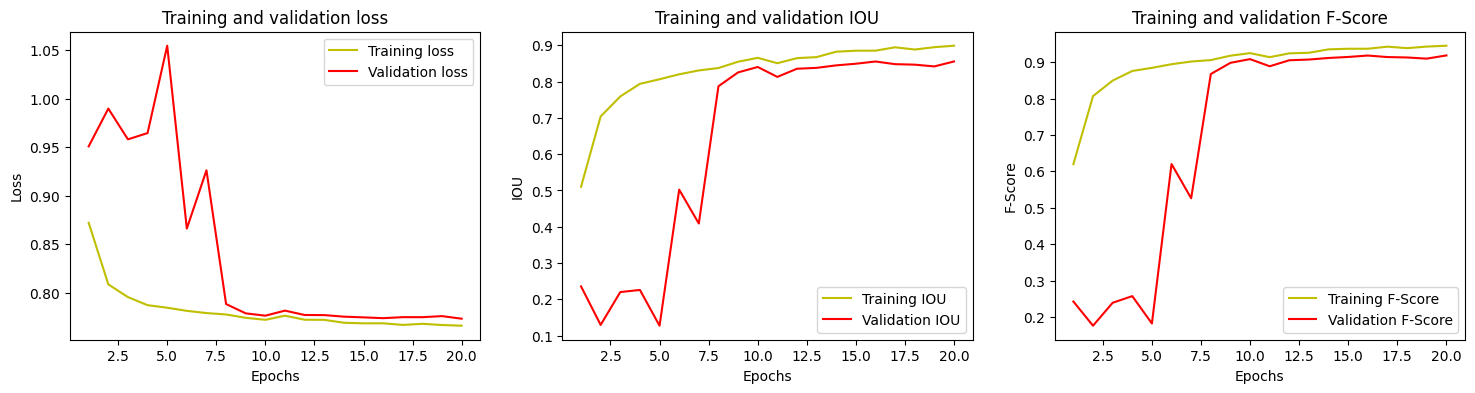

In [8]:
# generate plots from the acquired metrics of the training
loss, val_loss, acc, val_acc = history.history['loss'], history.history['val_loss'], history.history['iou_score'], history.history['val_iou_score']
fscore, val_fscore = history.history['f1-score'], history.history['val_f1-score']
epochs = range(1, len(loss) + 1)

# Write the training history to a CSV file
with open(f'{model_name}_training_history.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Loss', 'Val Loss', 'Accuracy', 'Val Accuracy', 'F-Score', 'Val F-Score'])
    writer.writerows(zip(epochs, loss, val_loss, acc, val_acc, fscore, val_fscore))

# Plot the training history
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(epochs, loss, 'y', label='Training loss')
axes[0].plot(epochs, val_loss, 'r', label='Validation loss')
axes[1].plot(epochs, acc, 'y', label='Training IOU')
axes[1].plot(epochs, val_acc, 'r', label='Validation IOU')
axes[2].plot(epochs, fscore, 'y', label='Training F-Score')
axes[2].plot(epochs, val_fscore, 'r', label='Validation F-Score')

[ax.set_xlabel('Epochs') for ax in axes] and [ax.legend() for ax in axes]

axes[0].set_title('Training and validation loss')
axes[0].set_ylabel('Loss')
axes[1].set_title('Training and validation IOU')
axes[1].set_ylabel('IOU')
axes[2].set_title('Training and validation F-Score')
axes[2].set_ylabel('F-Score')

plt.savefig(f'/content/{model_name}_metrics_plot.png')
plt.show()


In [9]:
# generate the test results and compile them into a .csv
model = load_model(f'/content/{model_name}_model.h5', compile=False) # comment out this line, if you didnt save the model in the step before

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
precision = Precision()
recall = Recall()

mean_iou = 0.0
mean_f1 = 0.0

for i in range(len(x_test)):
    test_img = x_test[i]
    test_img_gt = y_test[i]

    test_img_input = np.expand_dims(test_img, 0)
    test_img_pred = np.argmax(model.predict(test_img_input, verbose=0), axis=3)[0, :, :]

    # Calculate IUO (Intersection over Union) and update state
    IOU_keras.update_state(test_img_gt[:, :, 0], test_img_pred)
    mean_iou += IOU_keras.result().numpy()

    # Update state for Precision and Recall
    precision.update_state(test_img_gt[:, :, 0], test_img_pred)
    recall.update_state(test_img_gt[:, :, 0], test_img_pred)

    precision_result = precision.result().numpy()
    recall_result = recall.result().numpy()

    # Calculate F1 score
    f1_score = 2 * (precision_result * recall_result) / (precision_result + recall_result + 1e-10)
    mean_f1 += f1_score

mean_iou /= len(x_test)
mean_f1 /= len(y_test)

print("Mean IoU =", mean_iou)
print("Mean F1 Score =", mean_f1)

with open(f'{model_name}_test_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Metric', 'Value'])
    writer.writerow(['Mean IoU', mean_iou])
    writer.writerow(['Mean F1 Score', mean_f1])


Mean IoU = 0.7634057399431864
Mean F1 Score = 0.8656824061620243


1/1 [==============================] - 1s 1s/step


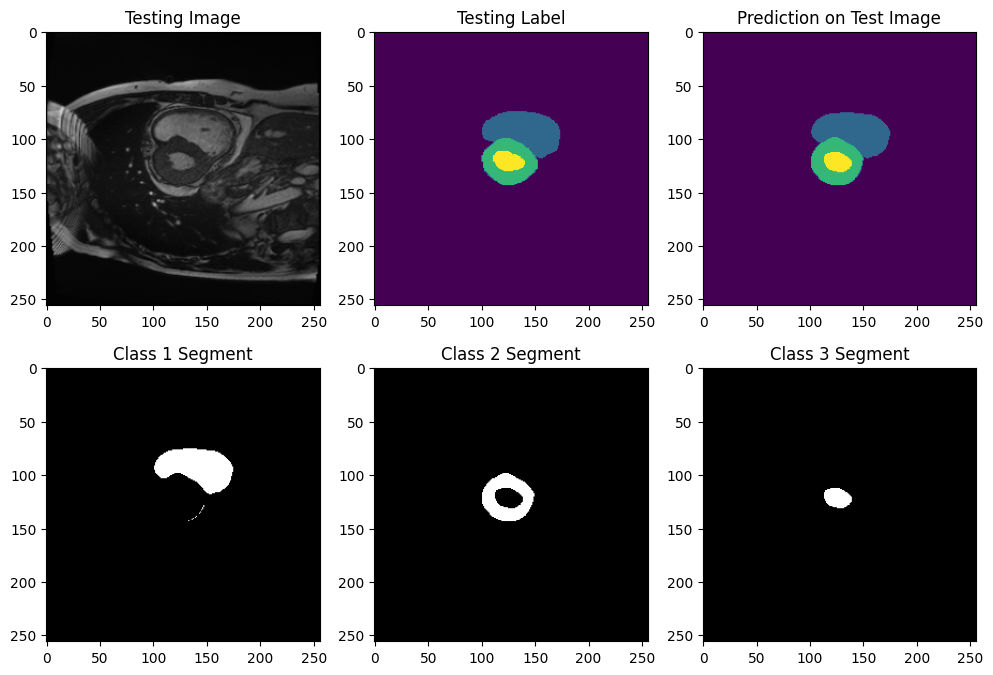

In [10]:
# test and compare the predicted image with the ground truth, and save the resulting plot
preprocess_input = sm.get_preprocessing(BACKBONE)
model = load_model(f'/content/{model_name}_model.h5', compile=False) # comment out this line, if you didnt save the model in the step before

img_num = random.randint(0, len(x_test) - 1)

test_img = x_test[img_num]
test_img_gt = y_test[img_num]

test_img_input = np.expand_dims(preprocess_input(test_img), 0)
test_img_pred = np.argmax(model.predict(test_img_input), axis=3)[0,:,:]

plt.figure(figsize=(12, 8))

# First row: Original image, Ground truth label, and Full prediction
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_img_gt)

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(test_img_pred)

# Second row: Displaying the segments of the three classes separately
class_segments = [np.where(test_img_pred == i + 1, i + 1, 0) for i in range(3)]
titles = ['Class 1 Segment', 'Class 2 Segment', 'Class 3 Segment']

for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.title(titles[i])
    plt.imshow(class_segments[i], cmap='gray')

plt.savefig(f'/content/{model_name}_prediction_plot.png')
plt.show()


In [11]:
# files.download(f'/content/{model_name}_metrics_plot.png')
# files.download(f'/content/{model_name}_model.h5')
# files.download(f'/content/{model_name}_prediction_plot.png')
# files.download(f'/content/{model_name}_test_results.csv')
# files.download(f'/content/{model_name}_training_history.csv')

# download all the files you want to keep
file_paths = [
    f'/content/{model_name}_metrics_plot.png',
    f'/content/{model_name}_prediction_plot.png',
    f'/content/{model_name}_test_results.csv',
    f'/content/{model_name}_training_history.csv'
]

with zipfile.ZipFile(f'/content/{model_name}_files.zip', 'w') as zip_file:
    for file_path in file_paths:
        zip_file.write(file_path, arcname=file_path.split('/')[-1])

files.download(f'/content/{model_name}_files.zip')

files.download(f'/content/{model_name}_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>